# Design an application for Public Healthcare

The agency of the "Public Health France" has launched a call for projects to find innovative ideas for food-related applications. The idea is to propose an application using the data from Open Food Facts, which is collaborative project with contributors from all ove the world.

https://world.openfoodfacts.org/

The data is available in the following link:

https://world.openfoodfacts.org/data

The variables of the data are described in the following link:

https://world.openfoodfacts.org/data/data-fields.txt

**The idea is to create an application that:**


**Classifies and shows low sodium products by their use or category (ex. appetizers, sauces, desserts, drinks, etc) and gives the nutri-score clasification.**


**Low-sodium diets are commonly prescribed to people with kidney disease, heart disease or high blood pressure in order to manage symptoms and prevent complications.**


In [1]:
import pandas as pd

# import numpy as np

# import matplotlib.pyplot as plt

# from matplotlib.collections import LineCollection

# Use seaborn style defaults and set the default figure size
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 6)})

# from sklearn.pipeline import make_pipeline

# from sklearn.preprocessing import StandardScaler

# from sklearn.decomposition import PCA

# import pingouin as pg

### Exploration of the data

In [2]:
data_food_facts = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t')

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,32,40,41,42,52,55,64,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print("The file contains {} rows and {} columns".format(data_food_facts.shape[0],data_food_facts.shape[1]))

The file contains 2054909 rows and 187 columns


In [4]:
data_food_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054909 entries, 0 to 2054908
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.9+ GB


The file encoding is Unicode UTF-8. The character that separates fields is <tab> (tabulation).

Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product
- nutrition_grade_fr : nutrition grade ('a' to 'e'). see https://fr.openfoodfacts.org/nutriscore
- nutrition-score-fr_100g : Nutri-Score - Nutrition score derived from the UK FSA score and adapted for the French market (formula defined by the team of Professor Hercberg). The fields are numeric ranging from -15 to 40. The lower the score, the better.

General information:

- code : barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
- url : url of the product page on Open Food Facts
- creator : contributor who first added the product
- created_t : date that the product was added (UNIX timestamp format)
- created_datetime : date that the product was added (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- last_modified_t : date that the product page was last modified
- last_modified_datetime
- product_name : name of the product
- generic_name
- quantity : quantity and unit



## Cleaning the data

### Revision of missing values

We need to know how many columns have more than 40% of missing values.

In [5]:
nan_values = 100 * data_food_facts.isna().sum() / len(data_food_facts) 
print ("The number of columns whose missing values are bigger than 40% is: {}".format(len(nan_values[nan_values > 40])))

The number of columns whose missing values are bigger than 40% is: 160


The next function creates a graph that shows the NaN values in each column of the dataframe passed to the function.

In [6]:
def graph_nan_values_per_column(data, size):

    nan_values = 100 * data.isna().sum() / len(data) 
    nan_values = nan_values.sort_values(ascending=False)
    nan_values = nan_values.astype(int)
    ax_nan_values = nan_values.plot(kind='barh', figsize=size, color='red')
    ax_nan_values.set_xlabel("Percentage of NaN values", fontsize='x-large')
    ax_nan_values.set_title("Percentage of NaN values \n in the data",fontsize='x-large')

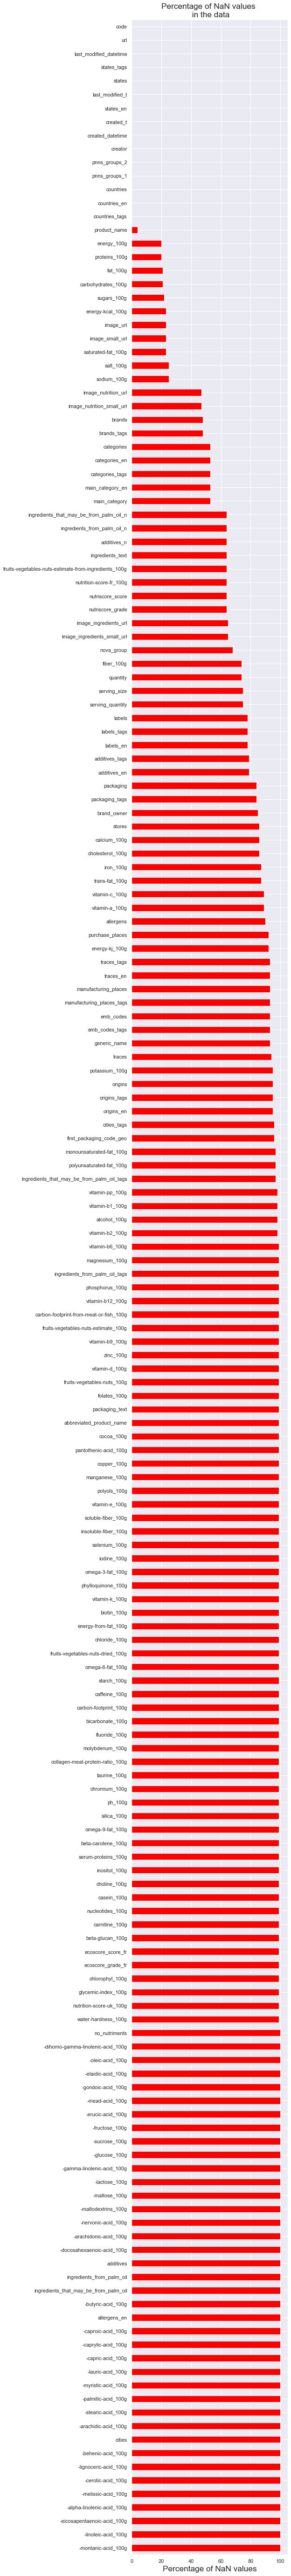

In [7]:
graph_nan_values_per_column(data_food_facts, (6,100))

In [8]:
for i in data_food_facts.columns:
    print (i)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
abbreviated_product_name
generic_name
quantity
packaging
packaging_tags
packaging_text
brands
brands_tags
categories
categories_tags
categories_en
origins
origins_tags
origins_en
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_en
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_en
ingredients_text
allergens
allergens_en
traces
traces_tags
traces_en
serving_size
serving_quantity
no_nutriments
additives_n
additives
additives_tags
additives_en
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutriscore_score
nutriscore_grade
nova_group
pnns_groups_1
pnns_groups_2
states
states_tags
states_en
brand_owner
ecoscore_score_fr
ecoscore_grade_fr


### Filtering the data in function of the important variables

We observe that the previous dataframe is pretty large and that is not ideal for exploration. So we are going to keep those columns that contain valuable information for the project formulation, which are those related to sodium and salt quantities. 

We also need some variables to validate our data, which we will see below.

Other variables such as the Code, Product Name, Nutriscore and Countries will be explored to start to filter our data.

In [9]:
data_food_facts_filtered_by_relevant_variables = data_food_facts[
    ['product_name', # name of the product
     'brands',
     'categories',
     'stores',
     'countries', # list of countries where the product is sold
     'additives_en',
     'main_category',
     'salt_100g', 
     'sodium_100g', 
     'cholesterol_100g', 
     'saturated-fat_100g',
     'fat_100g', 
     'trans-fat_100g', 
     'sugars_100g', 
     'carbohydrates_100g',
     'proteins_100g', 
     'fiber_100g', 
     'energy_100g',
     'nutrition-score-fr_100g',
     'nutriscore_grade',
     'image_ingredients_url',
     'code']] # code : barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix

In [10]:
# data_food_facts_filtered_by_relevant_variables.loc[data_food_facts_filtered_by_relevant_variables["code"] == "9556041600293"]['image_ingredients_url'].values

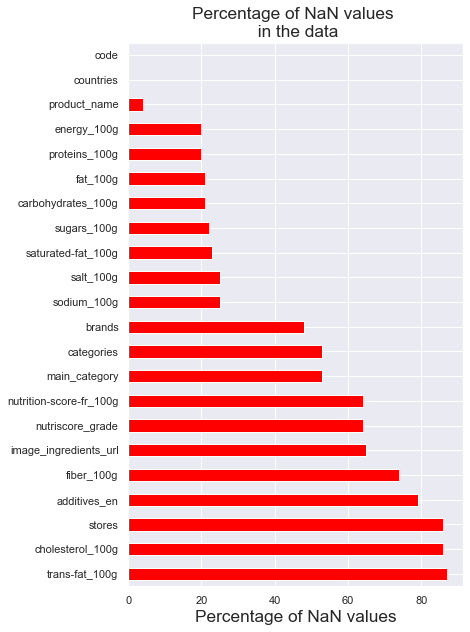

In [11]:
graph_nan_values_per_column(data_food_facts_filtered_by_relevant_variables, (6, 10))


From the previous graph we observe that some variables that we kept from the previous filtering still have a considerable percentage of missing data.

In [12]:
print("The data frame with the relevant variables contains now {} rows and {} columns".format(data_food_facts_filtered_by_relevant_variables.shape[0],data_food_facts_filtered_by_relevant_variables.shape[1]))

The data frame with the relevant variables contains now 2054909 rows and 22 columns


### Revision of duplicated values

We will check at the duplicate values by looking at the variable 'Code'.

In [13]:
print ("The number of duplicate values in the variable 'Code' is: {}".format(data_food_facts_filtered_by_relevant_variables.duplicated(subset=['code']).sum()))

The number of duplicate values in the variable 'Code' is: 319


There are 319 duplicate values for the variable 'Code' out of 2054909 rows. We will eliminate those duplicated values.

In [14]:
data_food_facts_filtered_by_relevant_variables.drop_duplicates(inplace=True, subset=['code'])

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
print ("The number of duplicate values in the variable 'Code' is: {}".format(data_food_facts_filtered_by_relevant_variables.duplicated(subset=['code']).sum()))

The number of duplicate values in the variable 'Code' is: 0


We removed the dupplicated values and kept the variables that might be useful for the project.

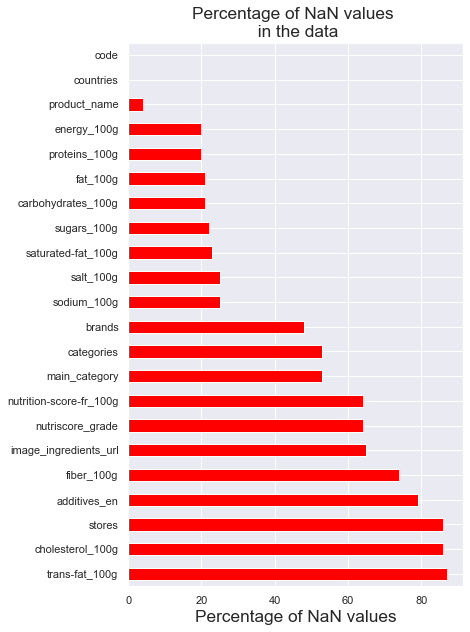

In [16]:
graph_nan_values_per_column(data_food_facts_filtered_by_relevant_variables, (6, 10))

In [17]:
print("The data frame with the relevant variables contains now {} rows and {} columns".format(data_food_facts_filtered_by_relevant_variables.shape[0],data_food_facts_filtered_by_relevant_variables.shape[1]))

The data frame with the relevant variables contains now 2054590 rows and 22 columns


### Treating missing values 

Given the nature of our data, we will not replace NaN values with 0, mean or the meadian. This is first because we cannot add values to products that may change the statistics and the distributions. Moreover, we will apply more filters for the data validation that we will see below.

### Treatment of aberrant values: data validation

In [18]:
data_food_facts_filtered_by_relevant_variables.describe()

,salt_100g,sodium_100g,cholesterol_100g,saturated-fat_100g,fat_100g,trans-fat_100g,sugars_100g,carbohydrates_100g,proteins_100g,fiber_100g,energy_100g,nutrition-score-fr_100g
count,1.523258e+06,1.523255e+06,268984.000000,1.573472e+06,1.621962e+06,264954.000000,1.600814e+06,1.621548e+06,1.623261e+06,5.185520e+05,1.630186e+06,730993.000000
mean,6.560690e+04,2.624281e+04,0.055349,6.351608e+04,7.330625e+07,0.150308,6.253066e+07,6.165679e+04,6.157176e+04,1.892438e+41,4.088833e+36,9.113163
std,8.096942e+07,3.238780e+07,1.759469,7.966696e+07,8.664786e+10,29.553317,7.903688e+10,7.847708e+07,7.843566e+07,1.362755e+44,5.220571e+39,8.850129
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000e+00,-1.000000e+00,-5.000000e+02,-2.000000e+01,0.000000e+00,-15.000000
25%,8.000000e-02,3.200000e-02,0.000000,1.000000e-01,8.000000e-01,0.000000,6.000000e-01,3.500000e+00,1.300000e+00,0.000000e+00,4.180000e+02,1.000000
50%,5.800000e-01,2.320000e-01,0.000000,1.800000e+00,7.000000e+00,0.000000,3.570000e+00,1.510000e+01,6.000000e+00,1.600000e+00,1.079000e+03,10.000000
75%,1.400000e+00,5.600000e-01,0.022000,7.100000e+00,2.120000e+01,0.000000,1.750000e+01,5.300000e+01,1.250000e+01,3.600000e+00,1.674000e+03,16.000000
max,9.993273e+10,3.997309e+10,362.000000,9.993273e+10,1.100000e+14,14800.000000,1.000000e+14,9.993273e+10,9.993273e+10,9.813275e+46,6.665559e+42,40.000000


We need somehow to validate the data so that it corresponds to reality. For this we can check some simple rules:

   - The quantity in grams of carbohydrates should be bigger than sugar.
   - The quantity in grams of fat should be bigger than saturated and trans fat.
   - The sum of fat, carbohydrates, proteins, fiber and salt should add to less or equal than 100 grams.
   - We will keep only the rows where for example sugar_100g and others are positive.


**We will keep only the rows where for example sugar_100g and others are positive.**

In [19]:
data_food_facts_filtered_by_relevant_variables = data_food_facts_filtered_by_relevant_variables[(data_food_facts_filtered_by_relevant_variables['sugars_100g']  >= 0) 
                                                & (data_food_facts_filtered_by_relevant_variables['proteins_100g']  >= 0) 
                                                & (data_food_facts_filtered_by_relevant_variables['carbohydrates_100g']  >= 0)
                                                & (data_food_facts_filtered_by_relevant_variables['fiber_100g']  >= 0)]

In [20]:
print("The data frame with the relevant variables contains now {} rows and {} columns".format(data_food_facts_filtered_by_relevant_variables.shape[0],data_food_facts_filtered_by_relevant_variables.shape[1]))

The data frame with the relevant variables contains now 508170 rows and 22 columns


**We will keep only the rows where carbohydrates are bigger or equal to sugars.**

In [21]:
data_food_facts_filtered_by_relevant_variables = data_food_facts_filtered_by_relevant_variables[data_food_facts_filtered_by_relevant_variables['carbohydrates_100g'] >= data_food_facts_filtered_by_relevant_variables['sugars_100g']]

**We will keep only the rows where fat is bigger or equal to saturated and trans fat. Also the sum of trans and saturated fats should be less than total fat content per 100g.**

In [22]:
data_food_facts_filtered_by_relevant_variables = data_food_facts_filtered_by_relevant_variables[(data_food_facts_filtered_by_relevant_variables['fat_100g']  >= data_food_facts_filtered_by_relevant_variables['saturated-fat_100g']) 
                                                & (data_food_facts_filtered_by_relevant_variables['fat_100g']  >= data_food_facts_filtered_by_relevant_variables['trans-fat_100g'])
                                                & (data_food_facts_filtered_by_relevant_variables['saturated-fat_100g'] + data_food_facts_filtered_by_relevant_variables['trans-fat_100g'] <= data_food_facts_filtered_by_relevant_variables['fat_100g'])]

**We will keep only the products where the quantites of fat, carbohydrates, proteins, fiber and salt add to less than 100 grams.**


We will keep the rows that contain values that are possible by definition according to the established rules.

In [23]:
data_food_facts_filtered_by_relevant_variables = data_food_facts_filtered_by_relevant_variables[
    data_food_facts_filtered_by_relevant_variables['fiber_100g']+ 
    data_food_facts_filtered_by_relevant_variables['salt_100g'] + 
    data_food_facts_filtered_by_relevant_variables['fat_100g'] + 
    data_food_facts_filtered_by_relevant_variables['proteins_100g'] + 
    data_food_facts_filtered_by_relevant_variables['carbohydrates_100g'] <= 100]

In [24]:
data_food_facts_filtered_by_relevant_variables.describe() 

,salt_100g,sodium_100g,cholesterol_100g,saturated-fat_100g,fat_100g,trans-fat_100g,sugars_100g,carbohydrates_100g,proteins_100g,fiber_100g,energy_100g,nutrition-score-fr_100g
count,213996.000000,213996.000000,212254.000000,213996.000000,213996.000000,213996.000000,213996.000000,213996.000000,213996.000000,213996.000000,213601.000000,193907.000000
mean,1.238011,0.495207,0.039663,4.075873,10.715881,0.033794,14.329648,32.021267,7.242566,1.851611,1054.881900,8.556679
std,3.725091,1.490036,1.113710,6.299592,13.521522,0.410913,19.087392,27.762173,8.060134,2.662877,687.390436,9.080842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000
25%,0.137160,0.054864,0.000000,0.000000,0.220000,0.000000,1.300000,7.140000,1.639344,0.000000,403.000000,1.000000
50%,0.720000,0.288000,0.000000,1.250000,5.360000,0.000000,5.000000,22.350000,4.710000,1.000000,1046.000000,10.000000
75%,1.422400,0.568960,0.026000,6.160000,17.020000,0.000000,21.840000,56.250000,10.000000,2.900000,1586.000000,16.000000
max,100.000000,40.000000,116.915000,100.000000,100.000000,35.710000,100.000000,100.000000,90.910000,72.500000,13213.000000,38.000000


An interesting observation from the filtered data is that cholesterol_100g maximum value is above 100. It would be convenient to verify the cholesterol and sodium values based on their units. The reason is products labels could report cholesterol and sodium values in mg per 100 g of product. If a cholesterol or sodium value is above 100 still makes sense if its units are mg. However in the data it is not specified what are such values units.

We will explore if the units are indeed consistent. We will search for some products in our dataframe. We start by looking at two random products as follows:

In [25]:
data_food_facts_filtered_by_relevant_variables.loc[(data_food_facts_filtered_by_relevant_variables['product_name']=='Ayam brand, sardines in extra virgin olive oil')]

,product_name,brands,categories,stores,countries,additives_en,main_category,salt_100g,sodium_100g,cholesterol_100g,...,trans-fat_100g,sugars_100g,carbohydrates_100g,proteins_100g,fiber_100g,energy_100g,nutrition-score-fr_100g,nutriscore_grade,image_ingredients_url,code
2045201,"Ayam brand, sardines in extra virgin olive oil",Ayam Brand,"Canned foods, Seafood, Fishes, Sardines",NaN,"France, United States",NaN,en:sardines,0.8925,0.357,0.036,...,0.0,0.0,7.14,14.29,0.0,1197.0,11.0,d,https://images.openfoodfacts.org/images/produc...,9556041600293


By looking at the product description in the link of Open Food Facts: 

https://world.openfoodfacts.org/product/9556041600293/ayam-brand-sardines-in-extra-virgin-olive-oil, 

we observed that the value of cholesterol per 100 g of product is 36 mg. However, in the data we have 0.036, which means the original values was divided by 1000.

On the other hand, the sodium per 100 g of product from our data has a value of 0.357. The value from the label is 257 mg per 100 g of product and is not exactly the same as the previous.

In [26]:
data_food_facts_filtered_by_relevant_variables.loc[(data_food_facts_filtered_by_relevant_variables['product_name']=='Red onion and thyme fresh spreadable cheese')]

,product_name,brands,categories,stores,countries,additives_en,main_category,salt_100g,sodium_100g,cholesterol_100g,...,trans-fat_100g,sugars_100g,carbohydrates_100g,proteins_100g,fiber_100g,energy_100g,nutrition-score-fr_100g,nutriscore_grade,image_ingredients_url,code
240519,Red onion and thyme fresh spreadable cheese,Norseland Inc,"Dairies, Fermented foods, Fermented milk produ...",Whole Foods,United States,NaN,en:cheeses,1.34,0.536,53.571,...,0.0,3.57,3.57,7.14,0.0,1046.0,14.0,d,NaN,75501246202


For this product description in the link of Open Food Facts: 

https://world.openfoodfacts.org/product/0075501246202/red-onion-and-thyme-fresh-spreadable-cheese-norseland-inc, 

we observed that the value of cholesterol per 100 g of product is 53.571 mg	and in our data we have the same value.

On the other hand, the sodium per 100 of product in our data is 0.536. However, from an external source of data (see https://www.instacart.com/products/3198219-snofrisk-red-onion-and-thyme-fresh-spreadable-cheese-4-4-oz), we found that the sodium per serving (28 g) is 150 mg. If we make the calculation, pero 100 g of product is exactly 535.7 mg.

**From a revision by hand of some values of cholesterol content in the products, we compared those from our data and from the Open Food Facts website. We found that these that are smaller than 1, are divided by 1000. But some of the values that are larger than 1, are consistent with the indicated in the Open Food Facts website.** 

**In order to use the values of cholesterol_100g from the data, is necessary careful review of these values. We cannot assume that all the values smaller than 1 are divided by 1000 and we cannot assume that the rest of the values are correct. Nor we cannot perform a units reconversion since we risk of modifying values that are correct.**

**Conversely, by exploring the content of sodium in the products, we observed that sodium_100g values are not larger than 100. However we did observe from the exploration of the two products chosen randomly that some of the sodium values are modified as well by being divided by 1000.**

**However we do not have information of what are the values that are modified because sodium_100g values from the Open Food Facts website are barely reported, so we are not able to compare such values. Further review is necessary to use these values.**

In [27]:
print("The data frame with the relevant variables contains now {} rows and {} columns".format(data_food_facts_filtered_by_relevant_variables.shape[0],data_food_facts_filtered_by_relevant_variables.shape[1]))

The data frame with the relevant variables contains now 213996 rows and 22 columns


Missing values of the filtered data, which has now 213996 rows and 22 columns, are described in the following graph.

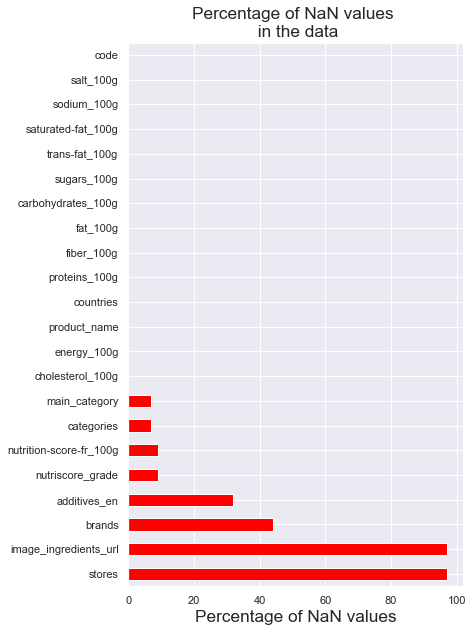

In [28]:
graph_nan_values_per_column(data_food_facts_filtered_by_relevant_variables, (6, 10))

### Pickling the cleaned and filtered data frame

After cleaning and filtering our data we pickle the already cleaned and filtered data frame. Pickle is used for serializing and de-serializing Python object structures, also called marshalling or flattening. Serialization refers to the process of converting an object in memory to a byte stream that can be stored on disk or sent over a network. Later on, this character stream can then be retrieved and de-serialized back to a Python object. For more details, consult references:

https://www.datacamp.com/community/tutorials/pickle-python-tutorial

https://docs.python.org/3/library/pickle.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_pickle.html

In [29]:
# To pickle the data frame

data_food_facts_filtered_by_relevant_variables.to_pickle("./pickle_data_cleaned.pkl")